In [139]:
# General use libraries
import os
import random

# Data related libraries
import numpy as np
import pandas as pd
from sktime.datasets import load_from_arff_to_dataframe

# Plotting libraries
import seaborn
import matplotlib.pyplot as plt

# Features handling libraries
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, chi2

# Parameters handling libraries
from sklearn.model_selection import GridSearchCV

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Metrics
from sklearn import metrics


In [2]:
def combine_and_translate_classes(train_x: pd.DataFrame, train_y: np.array, class_labels: dict, classes_category: str) -> pd.DataFrame:
    y_dataframe = pd.DataFrame(data = train_y, columns=[classes_category])
    combined_data_frame =  pd.merge(train_x, y_dataframe, left_index=True, right_index=True, )
    for class_label_key in class_labels:
        class_label_value = class_labels[class_label_key]
        combined_data_frame.loc[combined_data_frame[classes_category] == class_label_key, classes_category] = class_label_value

    return combined_data_frame

In [119]:
PEMS_SF_DATA_PATH = "./PEMS-SF"
PEMS_SF_CLASSES_CATEGORY = "Day of the week"
PEMS_SF_CLASS_VALUES_MAPPER = {
    "1.0" : "Monday",
    "2.0" : "Tuesday",
    "3.0" : "Wednesday",
    "4.0" : "Thursday",
    "5.0" : "Friday",
    "6.0" : "Saturday",
    "7.0" : "Sunday",
}

train_x_pems_sf, train_y_pems_sf = load_from_arff_to_dataframe(
    os.path.join(PEMS_SF_DATA_PATH, "PEMS-SF_TRAIN.arff")
)
train_y_pems_sf_integers = list(map(lambda x: int(float(x)) - 1, train_y_pems_sf))

test_x_pems_sf, test_y_pems_sf = load_from_arff_to_dataframe(
    os.path.join(PEMS_SF_DATA_PATH, "PEMS-SF_TEST.arff")
)
test_y_pems_sf_integers = list(map(lambda x: int(float(x)) - 1, test_y_pems_sf))

pems_sf_columns = train_x_pems_sf.columns
pems_sf_train_translated = combine_and_translate_classes(\
    train_x_pems_sf, train_y_pems_sf, PEMS_SF_CLASS_VALUES_MAPPER, PEMS_SF_CLASSES_CATEGORY)

/home/samanu/.local/lib/python3.8/site-packages/sktime/datasets/_data_io.py:1108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_data["dim_" + str(dim)] = instance_list[dim]


In [4]:
U_WAVE_GESTURE_DATA_PATH = "./UWaveGestureLibrary"
U_WAVE_CLASSES_CATEGORY = "Gesture"
U_WAVE_GESTURE_CLASS_VALUES_MAPPER = {
    "1.0" : "Gesture 1",
    "2.0" : "Gesture 2",
    "3.0" : "Gesture 3",
    "4.0" : "Gesture 4",
    "5.0" : "Gesture 5",
    "6.0" : "Gesture 6",
    "7.0" : "Gesture 7",
    "8.0" : "Gesture 8",
}

U_WAVE_GESTURE_CLASS_VALUES_TO_COLOR_MAPPER = {
    "Gesture 1" : "red",
    "Gesture 2" : "green",
    "Gesture 3" : "blue",
    "Gesture 4" : "yellow",
    "Gesture 5" : "brown",
    "Gesture 6" : "black",
    "Gesture 7" : "grey",
    "Gesture 8" : "orange",
}


train_x_u_wave_gesture, train_y_u_wave_gesture = load_from_arff_to_dataframe(
    os.path.join(U_WAVE_GESTURE_DATA_PATH, "UWaveGestureLibrary_TRAIN.arff")
)
test_x_u_wave_gesture, test_y_u_wave_gesture = load_from_arff_to_dataframe(
    os.path.join(U_WAVE_GESTURE_DATA_PATH, "UWaveGestureLibrary_TEST.arff")
)

u_wave_gesture_train_translated = combine_and_translate_classes(\
    train_x_u_wave_gesture, train_y_u_wave_gesture, U_WAVE_GESTURE_CLASS_VALUES_MAPPER, U_WAVE_CLASSES_CATEGORY)

# #1 Exploratory Data Analysis

### #1.1 Class Equilibrium

In [5]:
def draw_class_equilibrium(y:np.array, class_labels, classes_category, count_label, title) -> None: 
    y_dataframe = pd.DataFrame(data = y, columns=[classes_category])
    y_dataframe[count_label] = 0
    y_dataframe = y_dataframe.groupby(classes_category, as_index=False).count()
    y_dataframe.reset_index()
    
    for class_label_key in class_labels:
        class_label_value = class_labels[class_label_key]
        y_dataframe.loc[y_dataframe[classes_category] == class_label_key, classes_category] = class_label_value
    
    y_dataframe.plot.bar(x = classes_category, y = count_label, title=title)
    plt.figure(figsize=(20, 5))
    plt.show()

##### #1.1.1 PEMS-SF
Some days of the weeks were skipped due to holidays or technical issues but the distribution wasn't changed so much.
<br/>
Count of classified days are somewhat similar.

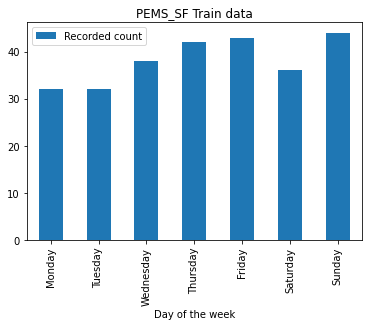

<Figure size 1440x360 with 0 Axes>

In [6]:
draw_class_equilibrium(train_y_pems_sf, PEMS_SF_CLASS_VALUES_MAPPER, PEMS_SF_CLASSES_CATEGORY, "Recorded count", "PEMS_SF Train data")

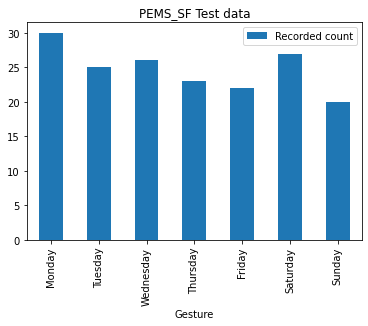

<Figure size 1440x360 with 0 Axes>

In [7]:
draw_class_equilibrium(test_y_pems_sf, PEMS_SF_CLASS_VALUES_MAPPER, U_WAVE_CLASSES_CATEGORY, "Recorded count", "PEMS_SF Test data")

##### #1.1.2 U_WAVE_GESTURE
This dataset is has an even class distribution both in train and test subsets.

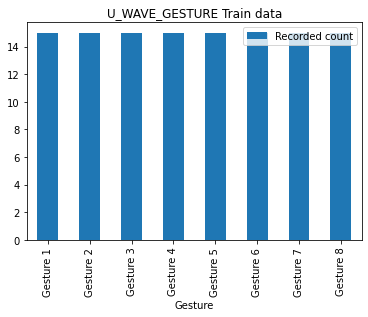

<Figure size 1440x360 with 0 Axes>

In [8]:
draw_class_equilibrium(train_y_u_wave_gesture, U_WAVE_GESTURE_CLASS_VALUES_MAPPER, U_WAVE_CLASSES_CATEGORY, "Recorded count", "U_WAVE_GESTURE Train data")

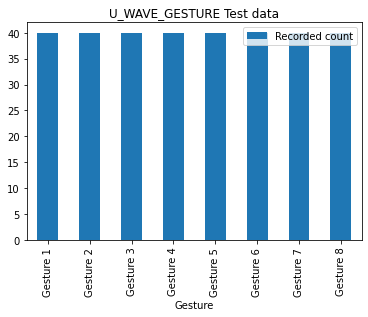

<Figure size 1440x360 with 0 Axes>

In [9]:
draw_class_equilibrium(test_y_u_wave_gesture, U_WAVE_GESTURE_CLASS_VALUES_MAPPER, U_WAVE_CLASSES_CATEGORY, "Recorded count", "U_WAVE_GESTURE Test data")


### #1.2 U Wave Gesture axis evolution

##### #1.2.1 Random example for each gesture

In [10]:
def plot_gesture_evolution(chosen_row: pd.Series, class_label_value: str) -> None:
    x_asis_evolution = chosen_row[0]
    y_asis_evolution = chosen_row[1]
    z_asis_evolution = chosen_row[2]
    
    number_of_points = len(x_asis_evolution)
    plot_x_axis = np.linspace(0, number_of_points - 1, number_of_points)
    plt.plot(plot_x_axis, x_asis_evolution, label="X Asis evolution")
    plt.plot(plot_x_axis, y_asis_evolution, label="Y Asis evolution", linestyle=":")
    plt.plot(plot_x_axis, z_asis_evolution, label="Z Asis evolution", linestyle="--")
    plt.xlabel("Time units")
    plt.ylabel("Position")
    plt.title(class_label_value)
    plt.legend()
    plt.figure(figsize=(20, 5))
    plt.show()


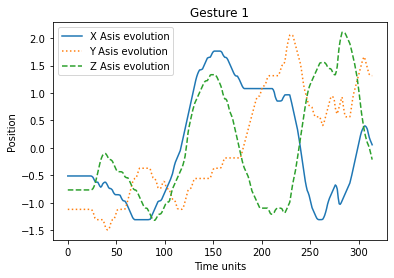

<Figure size 1440x360 with 0 Axes>

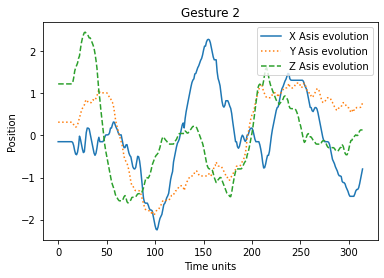

<Figure size 1440x360 with 0 Axes>

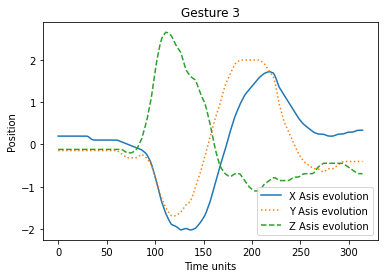

<Figure size 1440x360 with 0 Axes>

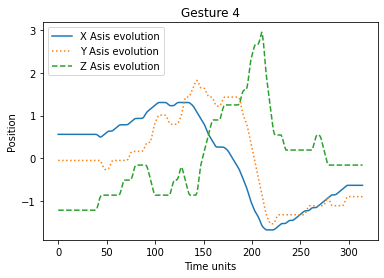

<Figure size 1440x360 with 0 Axes>

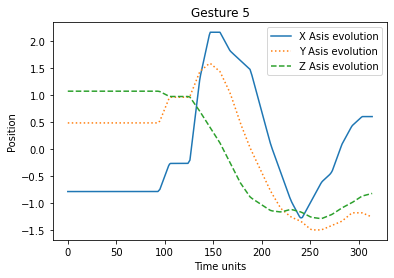

<Figure size 1440x360 with 0 Axes>

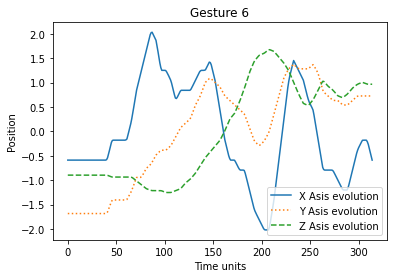

<Figure size 1440x360 with 0 Axes>

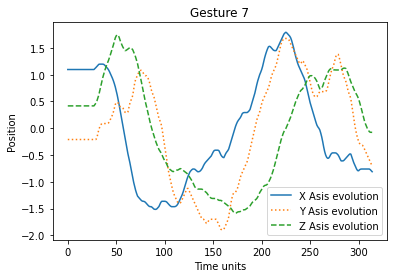

<Figure size 1440x360 with 0 Axes>

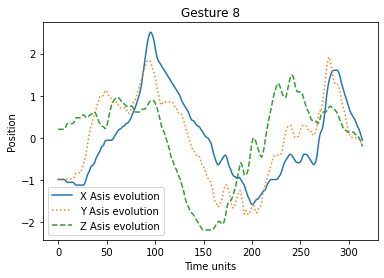

<Figure size 1440x360 with 0 Axes>

In [11]:
for class_label_key in U_WAVE_GESTURE_CLASS_VALUES_MAPPER.keys():
    class_label_value = U_WAVE_GESTURE_CLASS_VALUES_MAPPER[class_label_key]
    current_gesture_data_frame = u_wave_gesture_train_translated.loc[u_wave_gesture_train_translated[U_WAVE_CLASSES_CATEGORY] == class_label_value]
    number_of_rows = len(current_gesture_data_frame.index)
    chosen_index = random.randint(0, number_of_rows - 1)
    chosen_row =  current_gesture_data_frame.iloc[chosen_index]
    plot_gesture_evolution(chosen_row, class_label_value)

##### #1.2.2 Axis evolution distribution per gesture

In [12]:
def plot_axis_evolution(data_frame: pd.DataFrame, column_name: str, classes_category: str) -> None:
    axis_data_frame = data_frame[[column_name, classes_category]]
    
    grouped_by_class= dict()
    for index in range(0, len(axis_data_frame.index)):
        current_row = axis_data_frame.iloc[index]
        values_array = current_row[0]
        correct_class = current_row[1]
        value_for_current_series = values_array.mean()

        if correct_class in grouped_by_class:
            old_array = grouped_by_class[correct_class]
            old_array.append(value_for_current_series)
        else:
            grouped_by_class[correct_class] = [value_for_current_series]

    for correct_class in grouped_by_class:
        correct_class_values_distribution = grouped_by_class[correct_class]
        length = len(correct_class_values_distribution)
        plt.bar([0.0] + correct_class_values_distribution, ["0.0"] + ([correct_class] * length), \
            color=U_WAVE_GESTURE_CLASS_VALUES_TO_COLOR_MAPPER[correct_class], width=(10e-8 * 5), alpha=0.3, label=correct_class)

    plt.xlabel("Mean values")
    plt.ylabel(classes_category)
    plt.legend()
    plt.title("Axis distribution for {} per gesture".format(column_name))
    plt.figure(figsize=(20, 5))
    plt.show()

def plot_all_axis_evolution(data_frame: pd.DataFrame, classes_category: str) -> None:
    plot_axis_evolution(data_frame, "dim_0", classes_category)
    plot_axis_evolution(data_frame, "dim_1", classes_category)
    plot_axis_evolution(data_frame, "dim_2", classes_category)

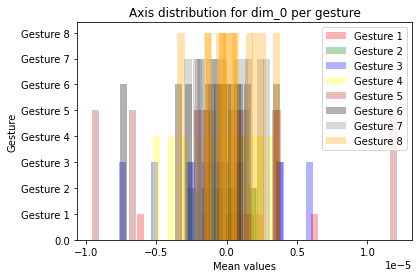

<Figure size 1440x360 with 0 Axes>

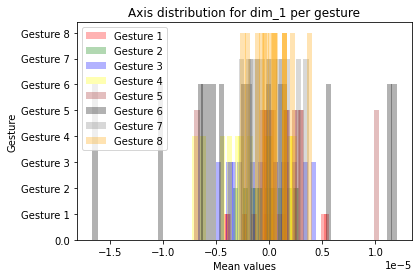

<Figure size 1440x360 with 0 Axes>

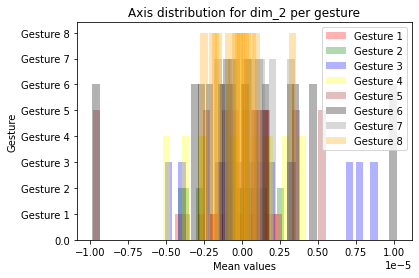

<Figure size 1440x360 with 0 Axes>

In [13]:
plot_all_axis_evolution(u_wave_gesture_train_translated, U_WAVE_CLASSES_CATEGORY)

### #1.3 PEMS-SF Analysis

#### #1.3.1 Best sensors deviation week days

In [14]:
NUMBER_OF_TOP_SENSORS = 10
NUMBER_OF_DAYS = 8

def standard_deviation(element):
    if type(element) == pd.Series:
        return element.std()
    else:
        return element

def fetch_days(data_frame: pd.DataFrame, class_labels: list, classes_category: str):
    new_data_frame = pd.DataFrame(columns=data_frame.columns)
    for class_label in class_labels:
        for days_index in range(0, NUMBER_OF_DAYS): 
            row = data_frame.loc[data_frame[classes_category] == class_label].iloc[days_index]
            new_data_frame.loc[len(new_data_frame.index)] = row
    
    random_row = data_frame.iloc[random.randint(0, len(data_frame.index))] 
    new_data_frame.loc[len(new_data_frame.index)] = random_row

    return new_data_frame

def find_top_sensors_by_std_sum_desc(data_frame : pd.DataFrame, sensors_columns: list) -> list:
    data_frame = data_frame.applymap(standard_deviation)
    sensor_ordered_array = []
    for sensor_column in sensors_columns:
        sensor_standard_deviations = data_frame[sensor_column]
        sensor_sum = sensor_standard_deviations.sum()
        sensor_ordered_array.append((sensor_column, sensor_sum))
    
    sensor_ordered_array.sort(key=lambda pair : pair[1], reverse=True)
    sensor_ordered_array = sensor_ordered_array[0: NUMBER_OF_TOP_SENSORS]
    chosen_sensors = list(map(lambda pair: pair[0], sensor_ordered_array))
    return chosen_sensors

def plot_occupation_rate_deviation_on_days(data_frame: pd.DataFrame, sensors: list, classes_category: str) -> None:
    data_frame = data_frame.applymap(standard_deviation)
    
    for chosen_sensor in sensors:
        sensor_data_frame = data_frame[[chosen_sensor, classes_category]]
        plt.figure(figsize=(20, 5))
        plt.title("Occupation rate variation for sensor {}".format(chosen_sensor))
        plt.xlabel(classes_category)
        plt.ylabel("Occupation rate")
        seaborn.boxplot(x = classes_category, y = chosen_sensor, data = sensor_data_frame)
        plt.show()


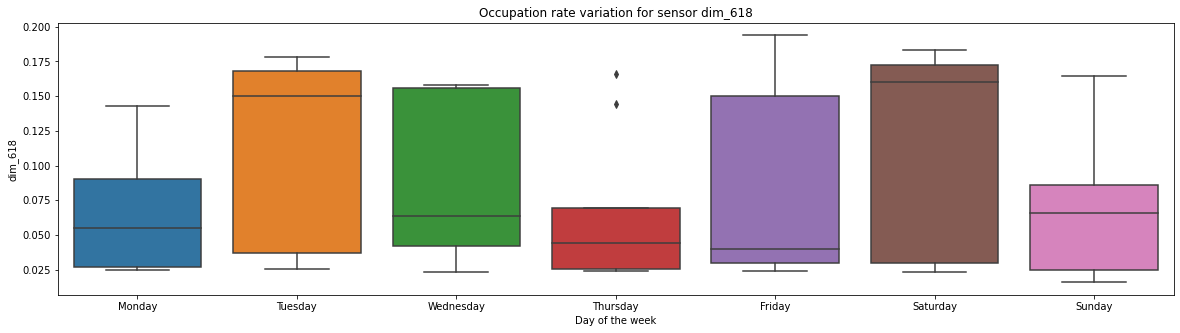

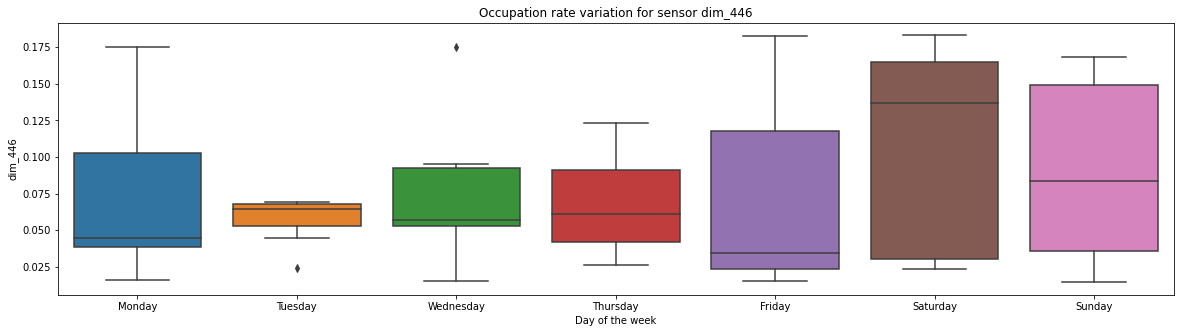

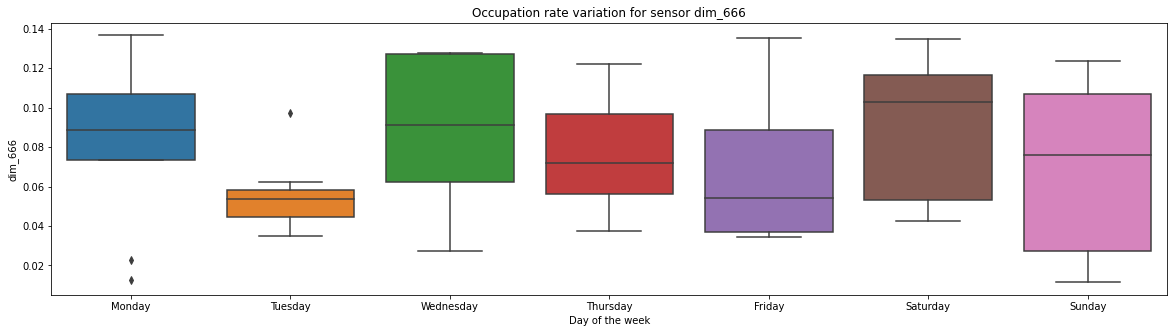

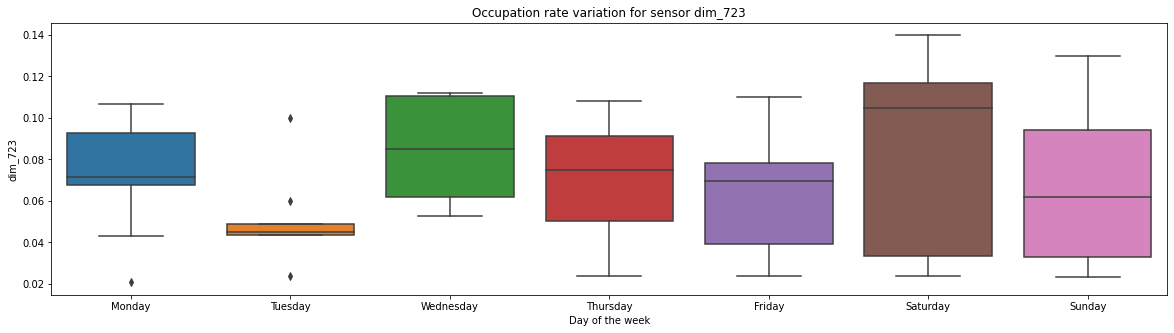

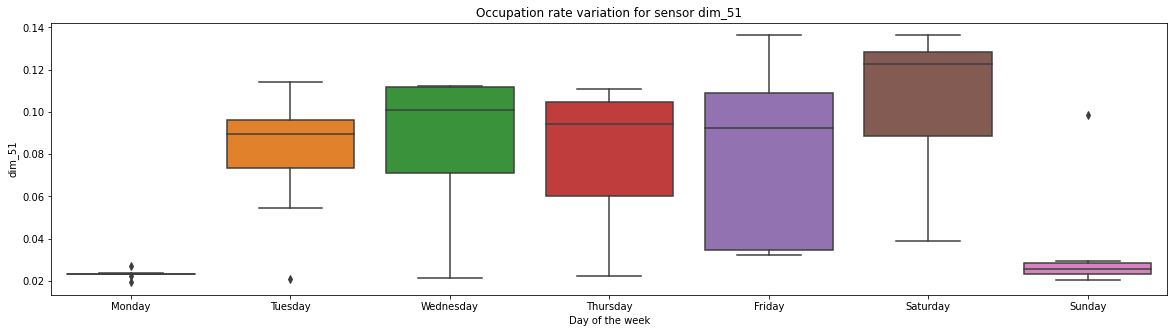

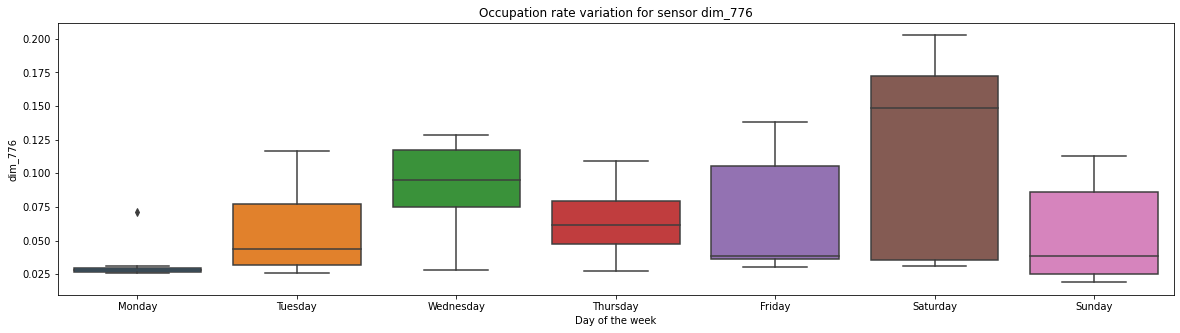

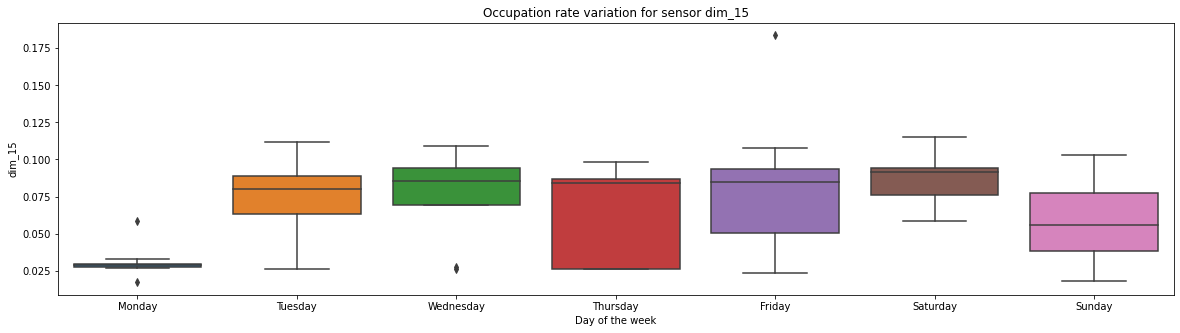

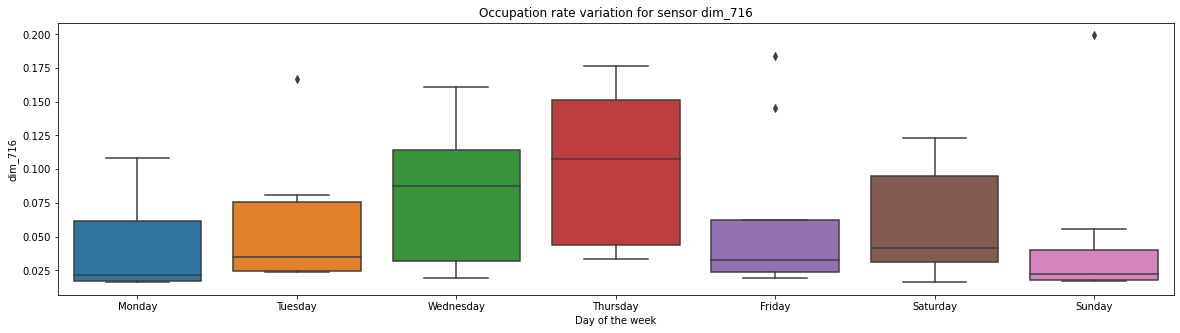

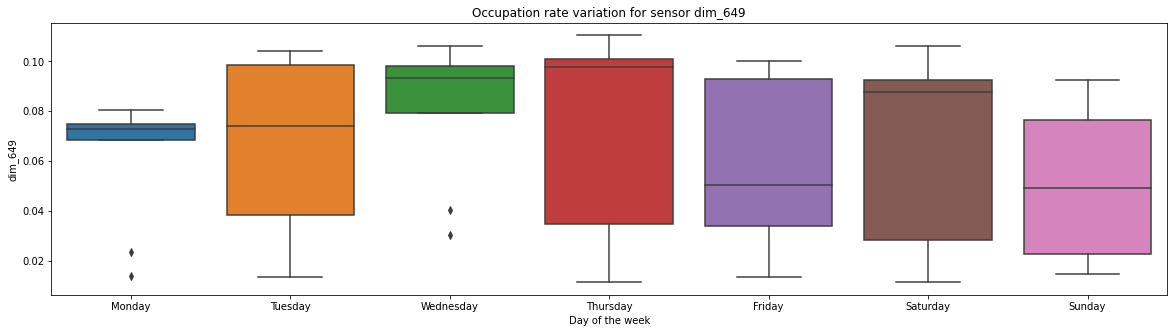

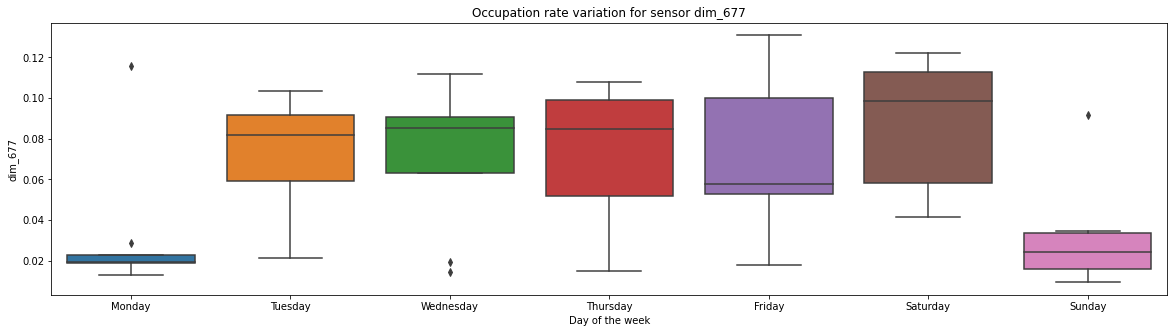

In [15]:
chosen_days_data_frame = fetch_days(pems_sf_train_translated, PEMS_SF_CLASS_VALUES_MAPPER.values(), PEMS_SF_CLASSES_CATEGORY)
chosen_sensors = find_top_sensors_by_std_sum_desc(chosen_days_data_frame, pems_sf_columns)
plot_occupation_rate_deviation_on_days(chosen_days_data_frame, chosen_sensors, PEMS_SF_CLASSES_CATEGORY)

#### #1.3.2 Best sensors occupation rate year evolution

In [16]:
def compute_mean_values_on_columns(data_frame: pd.DataFrame) -> pd.DataFrame:
    return data_frame.applymap(lambda x : x.mean())

def get_top_sensors_by_mean_values_std_desc(data_frame: pd.DataFrame, number_of_sensors: int):
    data_frame = compute_mean_values_on_columns(data_frame)
    return data_frame.std(axis = 0).sort_values(ascending = False)[0:number_of_sensors].index

In [17]:
top_sensors = get_top_sensors_by_mean_values_std_desc(train_x_pems_sf, NUMBER_OF_TOP_SENSORS)
mean_data_frame = compute_mean_values_on_columns(train_x_pems_sf)

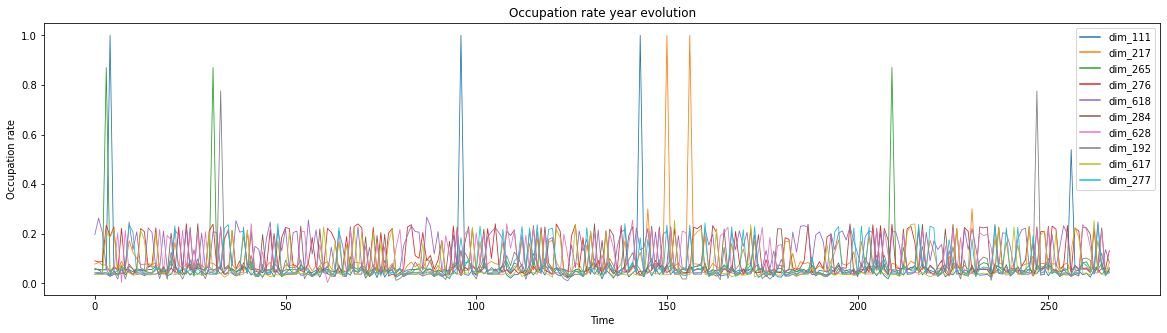

In [18]:
plt.figure(figsize=(20, 5))
plt.title("Occupation rate year evolution")
plt.xlabel("Time")
plt.ylabel("Occupation rate")
seaborn.lineplot(data = mean_data_frame[top_sensors], dashes=False, lw=0.8)
plt.show()

# #2 Feature selection & classic algorithms

## #2.1 PEMS-SF

In [134]:
from scipy.signal import argrelextrema

def get_number_of_peaks(values: pd.Series, peaks_neighbourhood_percentage: float = 0.02) -> int:
    return argrelextrema(np.array(values), np.less_equal, order = int(len(values) * peaks_neighbourhood_percentage) )[0].size 

def expand_pems_sf_data_set(data_set: pd.DataFrame):
    new_data_set = pd.DataFrame()
    for column_name in data_set.columns:
        current_column_data_set = data_set[column_name]
        new_data_set["mean_" + column_name] = current_column_data_set.apply(lambda x : x.mean())
        new_data_set["number_of_mins_" + column_name] = current_column_data_set.apply(lambda x : get_number_of_peaks(x))
        new_data_set["std_" + column_name] = current_column_data_set.apply(lambda x : x.std())
        new_data_set["max_" + column_name] = current_column_data_set.apply(lambda x : x.max())
        new_data_set["min_" + column_name] = current_column_data_set.apply(lambda x : x.min())
        new_data_set["difference_" + column_name] = current_column_data_set.apply(lambda x : abs(x.max() - x.min()))
        new_data_set["25_" + column_name] = current_column_data_set.apply(lambda x : np.percentile(x, 25))
        new_data_set["50_" + column_name] = current_column_data_set.apply(lambda x : np.percentile(x, 50))
        new_data_set["75_" + column_name] = current_column_data_set.apply(lambda x : np.percentile(x, 75))
        new_data_set["skew_" + column_name] = current_column_data_set.apply(lambda x : abs(x.skew()))
        new_data_set["kurtosis_" + column_name] = current_column_data_set.apply(lambda x : abs(x.kurtosis()))
    return new_data_set

def select_features(X: pd.DataFrame, y : pd.DataFrame, variance_threshold_percentage = 0.6, percentile=25) -> pd.DataFrame:
    X = VarianceThreshold(threshold=(variance_threshold_percentage * (1 - variance_threshold_percentage))).fit_transform(X)
    X = SelectPercentile(chi2, percentile=percentile).fit_transform(X, y)
    return pd.DataFrame(X)


def compute_grid_search_result(model_instance, parameters, X, y):
    grid_search_instance = GridSearchCV(model_instance, parameters)
    return grid_search_instance.fit(X, y)

def fit_predict_and_compute_metrics(model_definition, parameters, X_train, y_train, X_test, y_test):
    model_instance = model_definition(**parameters)
    model_instance.fit(X_train, y_train)
   
    y_predicted = model_instance.predict(X_test)
    accuracy_score = metrics.accuracy_score(y_test, y_predicted)
    precision_score = metrics.precision_score(y_test, y_predicted, average=None)
    recall_score = metrics.recall_score(y_test, y_predicted, average=None)
    f1_score = metrics.f1_score(y_test, y_predicted, average=None)
    confusion_matrix = metrics.confusion_matrix(y_test, y_predicted)
    return {
        "accuracy_score": accuracy_score,
        "precision_score": precision_score,
        "recall_score": recall_score,
        "f1_score": f1_score,
        "confusion_matrix": confusion_matrix,
    }

### Expand features

In [124]:
train_x_pems_sf_expanded = expand_pems_sf_data_set(train_x_pems_sf)
test_x_pems_sf_expanded = expand_pems_sf_data_set(test_x_pems_sf)

/tmp/ipykernel_3144/1166070056.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data_set["number_of_mins_" + column_name] = current_column_data_set.apply(lambda x : get_number_of_peaks(x))
/tmp/ipykernel_3144/1166070056.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data_set["std_" + column_name] = current_column_data_set.apply(lambda x : x.std())
/tmp/ipykernel_3144/1166070056.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

### Select features

In [125]:
train_rows = len(train_x_pems_sf_expanded)
test_rows = len(test_x_pems_sf_expanded)

full_X_features_expanded = pd.concat([train_x_pems_sf_expanded, test_x_pems_sf_expanded])
full_Y = np.concatenate((train_y_pems_sf, test_y_pems_sf))

print("Number of features after expansion = ", len(full_X_features_expanded.columns))
full_X_features_filtered = select_features(full_X_features_expanded, full_Y)
print("Number of features after selection = ", len(full_X_features_filtered[0]))

train_x_pems_sf_filtered = full_X_features_filtered[0: train_rows]
test_x_pems_sf_filtered = full_X_features_filtered[train_rows: len(full_X_features_expanded)]

Number of features after expansion =  10593
Number of features after selection =  440


### #2.1.1 Random forest

In [128]:
random_forest_parameters = {
    "max_depth": [5, 10, 15, 20],
    "n_estimators" : [10, 100, 200, 500],
    "min_samples_split" : [2, 5, 7]
}

random_forest_grid_search_result = compute_grid_search_result(
    RandomForestClassifier(),
    random_forest_parameters,
    train_x_pems_sf_filtered,
    train_y_pems_sf)

random_forest_result = fit_predict_and_compute_metrics(
    RandomForestClassifier,
    random_forest_grid_search_result.best_params_,
    train_x_pems_sf_filtered,
    train_y_pems_sf_integers,
    test_x_pems_sf_filtered,
    test_y_pems_sf_integers
)


### #2.1.2 SVM

In [130]:
svm_parameters = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [1, 2, 3, 4, 5],
    'degree': [1, 2, 3, 4, 5],
    'gamma' : ['scale', 'auto']
}

svm_grid_search_result = compute_grid_search_result(
    SVC(),
    svm_parameters,
    train_x_pems_sf_filtered,
    train_y_pems_sf)

svm_result = fit_predict_and_compute_metrics(
    SVC,
    svm_grid_search_result.best_params_,
    train_x_pems_sf_filtered,
    train_y_pems_sf_integers,
    test_x_pems_sf_filtered,
    test_y_pems_sf_integers
)

### #2.1.3 Gradient Boosted Trees

In [138]:
xgb_parameters = {
    'max_depth': [2, 4, 5],
    'n_estimators': [5, 50, 100],
    'learning_rate': [0.05, 0.1],
}

xgb_grid_search_result = compute_grid_search_result(
    XGBClassifier(),
    xgb_parameters,
    train_x_pems_sf_filtered,
    train_y_pems_sf_integers)

xgb_result = fit_predict_and_compute_metrics(
    XGBClassifier,
    xgb_grid_search_result.best_params_,
    train_x_pems_sf_filtered,
    train_y_pems_sf_integers,
    test_x_pems_sf_filtered,
    test_y_pems_sf_integers
)